# Precipitation exercises
***

## <font color=steelblue>Exercise 5 - Intensity-duration-frequency curves

<font color=steelblue>Build an IDF (intensity-duration-frequency) curve from the data in _hourly_precipitation_Oviedo.csv_.<tfont>

In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

**Intensity-Duration-Frequency (IDF) curves** are a common approach for defining a design storm in a hydrologic project. IDF curves relate rainfall intensity, storm duration and frequency (expressed as return period).
 
<img src="img/IDF curves.JPG" alt="Mountain View" style="width:500px">

> <font color=gray>Intensity-duration-frequency curve for Oklahoma City (Applied Hydrology. Chow, 1988).</font>

When designing a structure, the objetive is to know the precipitation intensity given a return period and a duration. We would know the return period we want to design the structure for (usually defined by laws or standards). We would have to find the worst case scenario for the duration; this is usually the time of concentration of the structure's basin.

**Empirical IDF curves**. To build a IDF curve out of local data, we must carry out a frequency analysis. As input values, we need an annual series of maximum precipitation intensity for several storm durations. We must fit the series for each storm duration to a extreme values distributions in order to estimate the precipitation intensity given a return period. This is the empirical IDF curve.

**Analytical IDF curves** are equations that allow us to create continuous curves from which extract intensity for any duration and return period, so we overcome the limitation of empirical curves. The parameters of the equations must be fitted to the observations, i.e., the points of the empirical IDF curves.

Steps to solve the exercise:
1. Import the data: hourly precipitation series.
2. Generate __series of annual maximum__ precipitation for several storm durations.
3. Fit a __GEV distribution__ to the series of annual maxima.
4. Estimate the points of the __empirical IDF__.
5. Fitting the __analytical IDF__.

### Import data

The input data is the hourly rainfall series in the meteorological station that the AEMET (Spanish Meteorological Agency) manages in Oviedo.

In [2]:
# load precipitation data
pcp_h = pd.read_csv('../data/hourly_precipitation_Oviedo_AEMET+SAIH.csv', parse_dates=True, index_col=0)
pcp_h.head()

,P(mm)
datetime,
2005-01-01 00:00:00,0.0
2005-01-01 01:00:00,0.0
2005-01-01 02:00:00,0.0
2005-01-01 03:00:00,0.0
2005-01-01 04:00:00,0.0


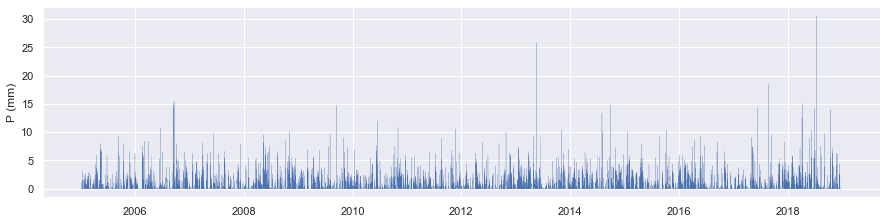

In [3]:
# visualize the hourly series
plt.figure(figsize=(15, 3.5))
plt.plot(pcp_h.index, pcp_h, lw=.2)
plt.ylabel('P (mm)');

### Generate series of annual maxima
To perfom a frequency analysis, we need a series with the maximum rainfall intensity in each of the years of the original data. Since our final goal is to derive an intensity-duration-frequency curve, we must repeat this process for several storm durations.

#### Example for 2h storm duration

In [4]:
# series of 2h rainfall intentity
pcp_2h = pcp_h.rolling(2, center=True).sum() 
int_2h = pcp_2h / 2
int_2h.columns = ['I[mm/h]']
int_2h.head()

,I[mm/h]
datetime,
2005-01-01 00:00:00,NaN
2005-01-01 01:00:00,0.0
2005-01-01 02:00:00,0.0
2005-01-01 03:00:00,0.0
2005-01-01 04:00:00,0.0


In [5]:
# series of annual maximum intensity for 2-h precipitation
annualMax_2h = int_2h.groupby(by=int_2h.index.year).max()
annualMax_2h

,I[mm/h]
datetime,
2005,6.80
2006,12.75
2007,6.15
2008,7.45
2009,11.30
2010,9.55
2011,7.85
2012,7.90
2013,14.40


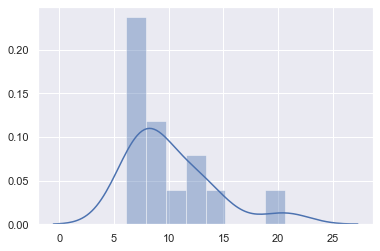

In [6]:
# visualize the data
sns.distplot(annualMax_2h, bins=8);

#### Loop for storm durations from 1 to 24 h
We can repeat all the previous steps for several durations in a loop, and save the series in a single data frame.

In [7]:
# durations to study
D = np.array([1, 2, 4, 8, 16, 24])

In [8]:
# series of annual maximum intensity for different storm durations
annualMax = pd.DataFrame(index=pcp_h.index.year.unique())

for d in D:
    int_d = pcp_h.rolling(d, center=True).sum() / d
    annualMax[d] = int_d.groupby(int_d.index.year).max()
annualMax

,1,2,4,8,16,24
datetime,,,,,,
2005,9.2,6.80,5.450,5.4375,4.68750,3.679167
2006,15.4,12.75,6.650,3.3375,2.23125,2.058333
2007,9.8,6.15,4.575,3.0250,2.61875,2.050000
2008,10.1,7.45,5.300,4.1125,2.70625,2.204167
2009,14.7,11.30,7.225,4.7750,2.63125,1.787500
2010,12.0,9.55,5.525,4.1250,3.61875,3.291667
2011,10.6,7.85,4.875,4.3125,3.24375,2.429167
2012,10.0,7.90,4.950,3.7500,2.37500,1.750000
2013,25.8,14.40,7.350,4.3125,2.65000,2.329167


### Fit a GEV distribution to the series of annual maxima

We must fit a extreme values distribution to the series of annual maxima. From the fitted distribution, we will be able to estimate the intensity for any return period.

We will use the **GEV distribution (generalized extreme values)**. When applied to exclusively positive values such as precipitation, the GEV distribution is:

$$F(s,\xi)=e^{-(1+\xi s)^{-1/\xi}}  \quad \forall \xi>0$$
$$ s = \frac{x-\mu}{\sigma} \quad \sigma>0$$

Where $s$ is the study variable standardised by the location parameter $\mu$ and the scale parameter $\sigma$, and $\xi$ is the shape parameter. So the GEV distribution has three parameters to be fitted.

<img src="img/Frechet.png" alt="Mountain View" style="width:600px">

> <font color=grey>Density function and the cumulative density function of the GEV type II (Frechet distribution) for several values of scale and shape.</font><br>

To fit the GEV distribution, we will use the function `genextreme.fit` in the package `scipy.stats`. The outputs of this function are the values of the three GEV parameters (shape, location and scale) that better fit the input data.

In [9]:
from scipy.stats import genextreme
from statsmodels.distributions.empirical_distribution import ECDF

#### Example: 2-hour storm

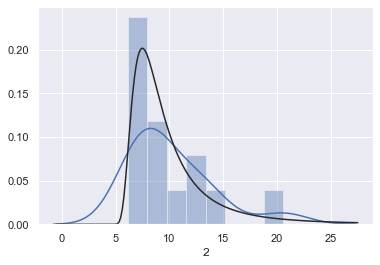

In [10]:
# visualize the data
sns.distplot(annualMax[2], bins=8, fit=genextreme);

In [11]:
# fit a GEV to the data
parGEV_2h = genextreme.fit(annualMax[2], f0=0)
print('Fitted parameters for the intensity in 1h-duration storms:')
print('xi = {0:.4f}\nmu = {1:.4f}\nsigma = {2:.4f}'.format(*parGEV_2h))

Fitted parameters for the intensity in 1h-duration storms:
xi = 0.0000
mu = 8.5781
sigma = 2.4754


In [12]:
# fit the empirical distribution
ecdf_2h = ECDF(annualMax[2])

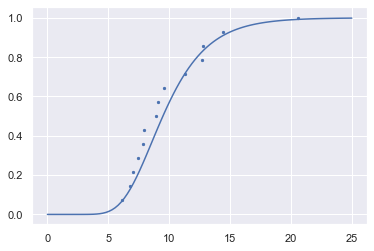

In [13]:
# visualize the fit
I = np.linspace(start=0, stop=25, num=100)
plt.plot(I, genextreme(*parGEV_2h).cdf(I))
plt.scatter(annualMax[2], ecdf_2h(annualMax[2]), s=5);

#### Loop for all storm durations
We'll repeat the process in a loop for all the storm durations. We'll save the results in a data frame called _parameters_.

In [14]:
# fit parameters for each duration
parameters = pd.DataFrame(index=['xi', 'mu', 'sigma'], columns=annualMax.columns)
for duration in annualMax.columns:
    # fit the GEV and save the parameters
    parameters[duration] = genextreme.fit(annualMax[duration], f0=0)
parameters

,1,2,4,8,16,24
xi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mu,11.782653,8.578091,5.715246,3.891118,2.686295,2.114238
sigma,3.750304,2.475405,1.096152,0.708824,0.432846,0.374510


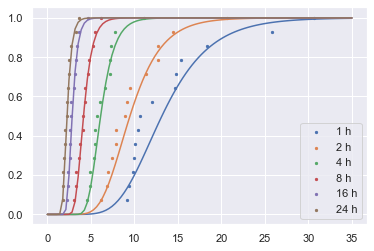

In [15]:
# visualize the fit
I = np.linspace(start=0, stop=35, num=100)
for d in D: # for each storm duration
    plt.plot(I, genextreme(*parameters[d]).cdf(I))
    plt.scatter(annualMax[d], ECDF(annualMax[d])(annualMax[d]), s=5, label=str(d) + ' h')
plt.legend();

### Empirical IDF

To calculate the empirical IDF we need to know the value of rainfall intensity for a given storm duration and return period. The storm duration defines which of the previously fitted GEV distributions to apply, whereas the return period defines the non-exceedance probability with which to enter the GEV distribution.

The **non-exceedance probability** (i.e., the value of the cumulative distribution function) and the **return period** are related by the equation: 

$$R = \frac{1}{1-CDF(x)}$$

Where $R$ is the return period and $CDF(x)$ the cumulative distribution function (or non-exceedance probability). From this expression, we can estimate the **non-exceedance probability** for a given **return period**:

$$CDF(x) = \frac{R-1}{R} = 1 - \frac{1}{R}$$

#### Example: 2-hour storm and 10 year return period
As an example, we will generate extreme values for a 2-h storm and the return period of 10 years. We'll use function `genextrem` in the package `scipy.stats`.

In [16]:
# set duration and return period
d = 2
Tr = 10
# non-exceedance probability associated to the return period
Pne = 1 - 1 / Tr
Pne

0.9

In [17]:
# rainfall intensity for a 2-h storm with 10 year return period
I_2h_10 = genextreme(*parameters[d]).ppf(Pne)
I_2h_10

14.148661611427219

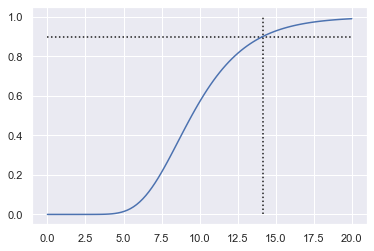

In [18]:
# visualize the fit
I = np.linspace(start=0, stop=20, num=100)
plt.plot(I, genextreme(*parameters[d]).cdf(I));
plt.hlines(Pne, 0, 20, linestyle=':')
plt.vlines(I_2h_10, 0, 1, linestyle=':');

#### Loop through all storm duration and all return periods
We can iterate the procedure across duration and return periods. Results will be saved in a *data frame*.

We will analyze return perios of 2, 10 and 30 years. Since our records span for only 10 years, we should not calculate larger return periods; as a rule of thumb, we can calculate return periods up to 3 times the span of our original records.

In [19]:
# return periods
R = np.array([2, 10, 30], dtype="float64")

In [20]:
# non-exceedance probability
Pne = 1. - 1. / R

We can calculate the 2-h rainfall intensity for all return periods at once.

In [21]:
# rainfall intensity
I_2h = genextreme(*parameters[2]).ppf(Pne) # ppf: percent point function

print('Rainfall intensity in 2 h storms at different return perios:')
for i, Tr in enumerate(R):
     print('I(Tr=', int(Tr), ') = ', round(I_2h[i], 1), ' mm/h', sep='')

Rainfall intensity in 2 h storms at different return perios:
I(Tr=2) = 9.5 mm/h
I(Tr=10) = 14.1 mm/h
I(Tr=30) = 17.0 mm/h


And iterate this step through a loop for all storm duration

In [22]:
# data frame with values of the IDF curve
IDFe = pd.DataFrame(index=R, columns=D)
IDFe.index.name = 'Tr'
for duration in D:
    IDFe[duration] = genextreme(*parameters[duration]).ppf(Pne)
IDFe

,1,2,4,8,16,24
Tr,,,,,,
2.0,13.157188,9.485359,6.117000,4.150911,2.844939,2.251501
10.0,20.222214,14.148662,8.181991,5.486232,3.660358,2.957024
30.0,24.474785,16.955591,9.424948,6.289987,4.151174,3.381691


In [23]:
# save results
IDFe.to_csv('../output/Ex5_Results empirical IDF.csv', float_format='%.1f')

Scatter plot that shows, for each return period, rainfall intensity as a function of storm duration.

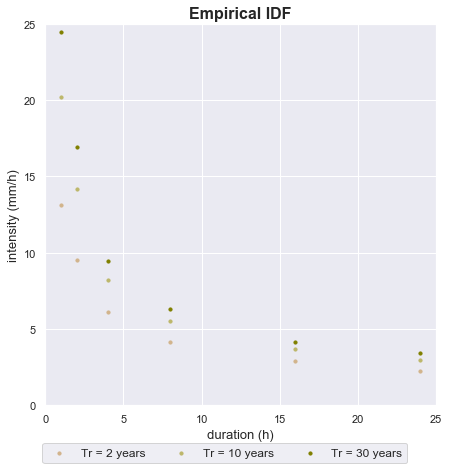

In [45]:
# configuración del gráfico
fig = plt.figure(figsize=(7, 7))
plt.title('Empirical IDF', fontsize=16, weight='bold')
plt.xlabel('duration (h)', fontsize=13)
plt.xlim(0, IDFe.columns.max() + 1)
plt.ylabel('intensity (mm/h)', fontsize=13)
plt.ylim((0, 25))
color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen']

for i, Tr in enumerate(R):
    plt.scatter(D, IDFe.loc[Tr,:], color=color[i], s=10, label='Tr = ' + str(int(Tr)) + ' years')

fig.legend(loc=8, ncol=3, fontsize=12);

# guardar la figura
plt.savefig('../output/Ex5_empirical IDFs.png', dpi=300)

### Analytical IDF curves

Up to now, we have calculated points of the IDF curves corresponding to paired values of duration and return period. We could iterate the process to get points for each storm duration in full hours, but still, we would have to interpolate between points to get intensity values for a storm duration of 2.5 h, for instance. To avoid that, there exist analytical forms of the IDF curve that take forms such as:

$$I = \frac{a \cdot R + b}{(D + c)^d}$$

$$I = \frac{a \cdot R + b}{D^c + d}$$

$$I = \frac{a \cdot R^b}{(D + c)^d}$$

$$I = \frac{a \cdot R^b}{D^c + d}$$

where $I$ is the precipitation intensity, $D$ storm duration, $R$ is return period, and $a$, $b$, $c$ and $d$ are location-specific parameters. We must optimize these parameters to our data so that the analytical IDF curves fit the empirical IDF points.

In [25]:
def IDF_type_I(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type I:
    
    I = (a * R + b) / (D + c)**d
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = (a * x[0] + b) / (x[1] + c)**d
    
    return I

In [26]:
def IDF_type_II(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type II:
    
    I = (a * R + b) / (D**c + d)   
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = (a * x[0] + b) / (x[1]**c + d)
    
    return I

In [27]:
def IDF_type_III(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type III:
    
    I = a * R**b / (D + c)**d
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = a * x[0]**b  / (x[1] + c)**d
    
    return I

In [28]:
def IDF_type_IV(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type IV:
    
    I = a * R**b / (D**c + d).    
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = (a * x[0]**b) / (x[1]**c + d)
    
    return I 

#### Fit the analytical IDF
To fit the analytical IDF we will use the function `curve_fit` in `scipy.optimize`. We must provide `curve_fit` with a function representing the curve to be fitted, the independent variable (paired values of return period-duration) and the dependent variable (itensity associated to the previous pairs). `curve_fit` puts out a vector with the optimized parameters and a vector with the covariance between those parameters.

In [29]:
from scipy.optimize import curve_fit

**Dependent variable in the IDF curve: intensity**

In [30]:
# 1D array of intensity for each pair of values in 'R' and 'D'
I = np.empty((0))
for d in D:
    I = np.concatenate((I, IDFe[d]))
print(I.shape)
I

(18,)


array([13.15718752, 20.22221377, 24.47478508,  9.48535899, 14.14866161,
       16.95559059,  6.11700001,  8.18199127,  9.42494809,  4.15091138,
        5.48623238,  6.28998704,  2.84493899,  3.66035781,  4.15117364,
        2.25150058,  2.95702363,  3.38169113])

**Independent variable in the IDF curve: paired values of return period and duration**

In [31]:
# grid with all possible combinations of duration and return period
(RR, DD) = np.meshgrid(R, D)
RR.shape, DD.shape

((6, 3), (6, 3))

In [32]:
# convert the grid ('RR' and 'DD') into a 1D array
RR = RR.reshape(-1)
DD = DD.reshape(-1)
RR.shape, DD.shape

((18,), (18,))

In [33]:
# join 'RR' and 'DD' as columns of a 2D array
RD = np.vstack([RR, DD])
RD.shape

(2, 18)

**Fit the curve**

In [34]:
# set type of curve
curve = IDF_type_IV

In [35]:
# fit the curve
parIDF, pcov = curve_fit(curve, RD, I)

print('Fitted parameters of the analytical IDF')
for i, par in enumerate(['a', 'b', 'c', 'd']):
    print(par, '=', round(parIDF[i], 4))

Fitted parameters of the analytical IDF
a = 15.445
b = 0.2069
c = 0.7053
d = 0.2642


In [36]:
# save the optimized parameters
IDFa = pd.DataFrame(parIDF, index=['a', 'b', 'c', 'd']).transpose()
IDFa

,a,b,c,d
0,15.445027,0.20686,0.705263,0.264202


In [37]:
# export results
IDFa.to_csv('../output/Ex5_Parameters analytical IDF.csv', float_format='%.5f')

**Visualize the fit**

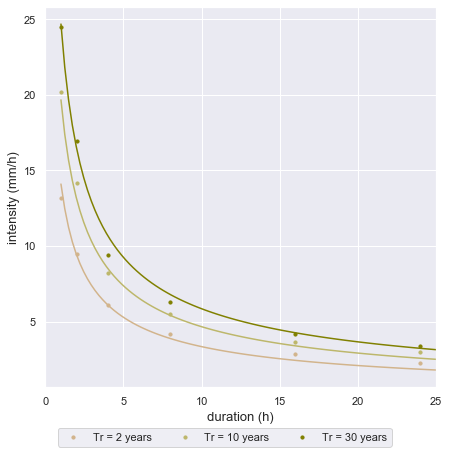

In [43]:
# plot the analytical IDF curves
fig = plt.figure(figsize=(7, 7))
plt.xlim(0, D.max()+1)
plt.xlabel('duration (h)', fontsize=13)
plt.ylabel('intensity (mm/h)', fontsize=13)
color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen']

D_ = np.linspace(1, 25, 100)

for i, Tr in enumerate(R):
    R_ = np.ones_like(D_) * Tr
    I_ = curve((R_, D_), *parIDF)

    plt.scatter(D, IDFe.loc[Tr,:], color=color[i], s=10, label='Tr = ' + str(int(Tr)) + ' years')
    plt.plot(D_, I_, color=color[i]);
    
fig.legend(loc=8, ncol=3)
    
# save figure
plt.savefig('../output/Ex5_analytical IDFs.png', dpi=300)